In [50]:
# Import libs
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import re as re
import json # library to handle JSON files

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.transforms
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

import folium 
import geocoder
import geopandas as gpd
import fiona

# 1.1. Prepare neighborhood list: Manhattan

In [750]:
url = 'https://en.wikipedia.org/wiki/List_of_Manhattan_neighborhoods'
results = requests.get(url)
soup = BeautifulSoup(results.content)

In [751]:
MA_info = soup.find_all('table', attrs = {'class':'wikitable sortable'})

In [752]:
MA_list = []
for area in MA_info:
    list_data = area.tbody.find_all('tr')
    for row in list_data[1:]:
        MA_list.append(row.find('td').text.replace('\n', '').strip())
    for index, neighborhood in enumerate(MA_list):
        try:
            MA_list[index] = re.split('[(,\[†]', neighborhood)[0].strip()
        except:
            pass
    for index, neighborhood in enumerate(MA_list):
        try:
            MA_list[index] = neighborhood.split(' aka ')[0].strip()
        except:
            pass
MA_list[-3] = MA_list[-3].replace('Historical District','').strip()
MA_list[62] = MA_list[62].replace('and Loisaida', '').strip()
MA_list

['Upper Manhattan',
 'Marble Hill',
 'Inwood',
 'Fort George',
 'Washington Heights',
 'Hudson Heights',
 'West Harlem',
 'Hamilton Heights',
 'Manhattanville',
 'Morningside Heights',
 'Central Harlem',
 'Harlem',
 'St. Nicholas Historic District',
 'Astor Row',
 'Sugar Hill',
 'Marcus Garvey Park',
 'Le Petit Senegal',
 'East Harlem',
 'Upper East Side',
 'Lenox Hill',
 'Carnegie Hill',
 'Yorkville',
 'Upper West Side',
 'Manhattan Valley',
 'Lincoln Square',
 'Columbus Circle',
 'Sutton Place',
 'Rockefeller Center',
 'Diamond District',
 'Theater District',
 'Turtle Bay',
 'Midtown East',
 'Midtown',
 'Tudor City',
 'Little Brazil',
 'Times Square',
 'Hudson Yards',
 'Midtown West',
 "Hell's Kitchen",
 'Garment District',
 'Herald Square',
 'Koreatown',
 'Murray Hill',
 'Tenderloin',
 'Madison Square',
 'Flower District',
 'Brookdale',
 'Hudson Yards',
 'Kips Bay',
 'Rose Hill',
 'NoMad',
 'Peter Cooper Village',
 'Chelsea',
 'Flatiron District',
 'Gramercy Park',
 'Stuyvesant Squa

# 1.2. Prepare neighborhood list: DC

In [753]:
url = 'https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Administrative_Other_Boundaries_WebMercator/MapServer/35/query?where=1%3D1&outFields=NAME&outSR=4326&f=json'
results = requests.get(url).json()
DC_list_full = json_normalize(results['features'])
DC_list_full.columns = ['Name', 'Latitude', 'Longitude']

<ipython-input-753-036be7523f7b>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  DC_list_full = json_normalize(results['features'])


In [754]:
DC_list_full['Name'] = DC_list_full['Name'].str.replace('-',' ', regex=False)

def name_correct(name, delimit='/'):
    return name.split(delimit)[0]

DC_list_full['Name'] = DC_list_full['Name'].apply(name_correct)
DC_list = DC_list_full['Name'].tolist()
DC_list

['Fort Stanton',
 'Congress Heights',
 'Washington Highlands',
 'Bellevue',
 'Knox Hill',
 'Shipley',
 'Douglass',
 'Woodland',
 'Garfield Heights',
 'Near Southeast',
 'Capitol Hill',
 'Dupont Park',
 'Twining',
 'Randle Highlands',
 'Fairlawn',
 'Penn Branch',
 'Barry Farm',
 'Historic Anacostia',
 'Columbia Heights',
 'Logan Circle',
 'Cardozo',
 'Van Ness',
 'Forest Hills',
 'Georgetown Reservoir',
 'Foxhall Village',
 'Fort Totten',
 'Pleasant Hill',
 'Kenilworth',
 'Eastland Gardens',
 'Deanwood',
 'Fort Dupont',
 'Greenway',
 'Woodland Normanstone',
 'Mass. Ave. Heights',
 'Naylor Gardens',
 'Pleasant Plains',
 'Hillsdale',
 'Benning Ridge',
 'Penn Quarter',
 'Chinatown',
 'Stronghold',
 'South Central',
 'Langston',
 'Downtown East',
 'North Portal Estates',
 'Colonial Village',
 'Shepherd Park',
 'Takoma',
 'Lamond Riggs',
 'Petworth',
 'Brightwood Park',
 'Manor Park',
 'Brightwood',
 'Hawthorne',
 'Barnaby Woods',
 'Queens Chapel',
 'Michigan Park',
 'North Michigan Park',
 

## * Function to generate points in polygon

In [755]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
import random

def random_points_in_polygon(number, polygon, seed=10):
    random.seed(seed)
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  # returns list of shapely point

# 1.3. Prepare neighborhood list: Beijing

In [756]:
# Density of neighborhood in DC
neighborhood_dens_DC = len(DC_list) / 68.34
neighborhood_dens_MA = len(MA_list) / 22.82
print('DC: {} per sq mi'.format(neighborhood_dens_DC))
print('MA: {} per sq mi'.format(neighborhood_dens_MA))

DC: 1.9315188762071993 per sq mi
MA: 3.6809815950920246 per sq mi


In [757]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
BJ_downtown = gpd.read_file('Beijing.kml', driver='KML')

In [758]:
num_BJ = int(neighborhood_dens_DC * 60.8)
points = random_points_in_polygon(num_BJ, BJ_downtown.iloc[0].geometry, seed=3)

# Coordinates of the first point
BJ_x = [point.x for point in points]
BJ_y = [point.y for point in points]

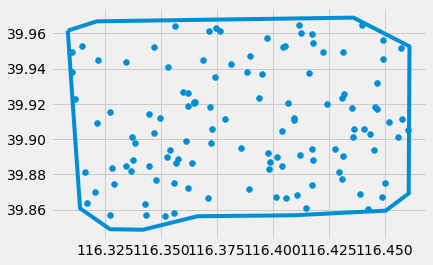

In [759]:
plt.plot(*BJ_downtown.iloc[0,2].exterior.xy)
plt.scatter(BJ_x, BJ_y)

# 1.4. Prepare neighborhood list: Shanghai

In [760]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
SH_downtown = gpd.read_file('Shanghai.kml', driver='KML')

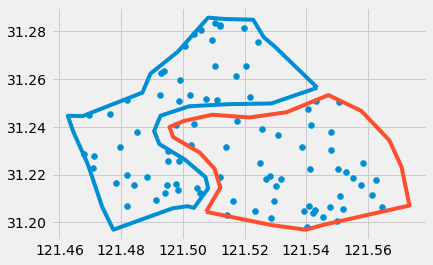

In [761]:
num_SH = int(neighborhood_dens_MA * 24.1/2)
seed0 = 9
points1 = random_points_in_polygon(num_SH, SH_downtown.iloc[0].geometry, seed=seed0)
points2 = random_points_in_polygon(num_SH, SH_downtown.iloc[1].geometry, seed=seed0)

# Coordinates of the first point
SH_x = [point.x for point in points1] + [point.x for point in points2]
SH_y = [point.y for point in points1] + [point.y for point in points2]
plt.plot(*SH_downtown.iloc[0,2].exterior.xy)
plt.plot(*SH_downtown.iloc[1,2].exterior.xy)
plt.scatter(SH_x, SH_y)

# 2. Request neighborhood position

## 2.1. Mahattan

In [762]:
lat = []
lng = []
for neighborhood in MA_list:
    address = '{}, New York, NY'.format(neighborhood)
    g = geocoder.arcgis(address)
    lat.append(g.lat)
    lng.append(g.lng)

In [763]:
MA_table = pd.DataFrame(MA_list)
MA_table.columns = ['Neighborhood']

In [764]:
MA_table['Latitude'] = lat
MA_table['Longitude'] = lng

In [765]:
for row in range(MA_table.shape[0]):
    if (MA_table.loc[row, 'Latitude'] <= 40.65526141744085) or (MA_table.loc[row, 'Longitude'] >= -73.81816282365787):
        MA_table.drop(row, inplace=True)
MA_table.reset_index(drop=True, inplace=True)

### 2.1.1. Map of Mahattan

In [766]:
address = 'New York, NY'
g = geocoder.arcgis(address)
print(g.lat, g.lng)

40.71455000000003 -74.00713999999994


In [767]:
map_newyork = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(MA_table['Neighborhood'], MA_table['Latitude'], MA_table['Longitude']):
    label = '{},{}'.format(lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_newyork)
map_newyork

## 2.1.2. Request venues from Foursquare

### * Define a required function

In [768]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    neighborhood_venues_info = []
    venues_info = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        neighborhood_venues_info.append(results)
        venues_info.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print(len(venues_info), ':', name)

    nearby_venues = pd.DataFrame([item for venue_info in venues_info for item in venue_info])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, venues_info, neighborhood_venues_info)

#### * Define Foursquare credential and version

In [769]:
CLIENT_ID = 'OQWZRAUBBN5XX5CTG4QJNUTGB1PLERCI32GLZWVRG4JJTOMN' # your Foursquare ID
CLIENT_SECRET = '5J0EYVSGK2QSQXGA4TN5YPIIUY1NU0HDIRQNHRWWB4BXUUAR' # your Foursquare Secret
ACCESS_TOKEN = 'VH53ZCZMIQSN033ZU2VDUZD1CRA5GJQE1SKGVRWNNF1FJINZ' # your FourSquare Access Token
VERSION = '20180605'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OQWZRAUBBN5XX5CTG4QJNUTGB1PLERCI32GLZWVRG4JJTOMN
CLIENT_SECRET:5J0EYVSGK2QSQXGA4TN5YPIIUY1NU0HDIRQNHRWWB4BXUUAR


In [773]:
names = MA_table['Neighborhood'].tolist()
latitudes = MA_table['Latitude'].tolist()
longitudes = MA_table['Longitude'].tolist()
# MA_venues, MA_venues_info, MA_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

1 : Upper Manhattan
2 : Marble Hill
3 : Inwood
4 : Fort George
5 : Washington Heights
6 : Hudson Heights
7 : West Harlem
8 : Hamilton Heights
9 : Manhattanville
10 : Morningside Heights
11 : Central Harlem
12 : Harlem
13 : St. Nicholas Historic District
14 : Astor Row
15 : Sugar Hill
16 : Marcus Garvey Park
17 : Le Petit Senegal
18 : East Harlem
19 : Upper East Side
20 : Lenox Hill
21 : Carnegie Hill
22 : Yorkville
23 : Upper West Side
24 : Manhattan Valley
25 : Lincoln Square
26 : Columbus Circle
27 : Sutton Place
28 : Rockefeller Center
29 : Diamond District
30 : Theater District
31 : Turtle Bay
32 : Midtown East
33 : Midtown
34 : Tudor City
35 : Little Brazil
36 : Times Square
37 : Hudson Yards
38 : Midtown West
39 : Hell's Kitchen
40 : Garment District
41 : Herald Square
42 : Koreatown
43 : Tenderloin
44 : Madison Square
45 : Hudson Yards
46 : Kips Bay
47 : Rose Hill
48 : NoMad
49 : Peter Cooper Village
50 : Flatiron District
51 : Gramercy Park
52 : Stuyvesant Square
53 : Union Squ

## 2.1.3. Save and Read already requested data

In [782]:
# Save requested data
# MA_table.to_csv('MA_table.csv',index=False)
# MA_venues.to_csv('MA_venues.csv',index=False)
# with open('MA_venues_info.txt','w') as fp:
#     json.dump(MA_venues_info, fp)
# with open('MA_neighborhood_venues_info.txt','w') as fp:
#     json.dump(MA_neighborhood_venues_info, fp)

In [3]:
# Load saved data
MA_table = pd.read_csv('MA_table.csv')
MA_venues = pd.read_csv('MA_venues.csv')
with open('MA_venues_info.txt', 'r') as fp:
    MA_venues_info_backup = json.load(fp)
with open('MA_neighborhood_venues_info.txt', 'r') as fp:
    MA_neighborhood_venues_info_backup = json.load(fp)

___
## 2.2. DC (similar steps as Manhattan)

In [776]:
lat = []
lng = []
for neighborhood in DC_list:
    address = '{}, Washington, DC'.format(neighborhood)
    g = geocoder.arcgis(address)
    lat.append(g.lat)
    lng.append(g.lng)

DC_table = pd.DataFrame(DC_list)
DC_table.columns = ['Neighborhood']
DC_table['Latitude'] = lat
DC_table['Longitude'] = lng

### 2.2.1. Map of DC

In [777]:
address = 'Washington, DC'
g = geocoder.arcgis(address)
print(g.lat, g.lng)

38.890370000000075 -77.03195999999997


In [778]:
map_DC = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(DC_table['Neighborhood'], DC_table['Latitude'], DC_table['Longitude']):
    label = '{},{}'.format(lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_DC)
map_DC

### 2.2.2. Request venues from Foursquare

In [ ]:
names = DC_table['Neighborhood'].tolist()
latitudes = DC_table['Latitude'].tolist()
longitudes = DC_table['Longitude'].tolist()
# DC_venues, DC_venues_info, DC_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

### 2.2.3. Read saved data

In [786]:
# Save requested data
# DC_table.to_csv('DC_table.csv', index=False)
# DC_venues.to_csv('DC_venues.csv',index=False)
# with open('DC_venues_info.txt','w') as fp:
#     json.dump(DC_venues_info, fp)
# with open('DC_neighborhood_venues_info.txt','w') as fp:
#     json.dump(DC_neighborhood_venues_info, fp)

In [32]:
# Load saved data
DC_table = pd.read_csv('DC_table.csv')
DC_venues = pd.read_csv('DC_venues.csv')
with open('DC_venues_info.txt', 'r') as fp:
    DC_venues_info_backup = json.load(fp)
with open('DC_neighborhood_venues_info.txt', 'r') as fp:
    DC_neighborhood_venues_info_backup = json.load(fp)

___
## 2.3. Beijing

In [790]:
BJ_list = []
for i in range(len(BJ_y)):
    name = 'Neighborhood{}'.format(i+1)
    BJ_list.append(name)
lat = BJ_y
lng = BJ_x

In [791]:
BJ_table = pd.DataFrame(BJ_list)
BJ_table.columns = ['Neighborhood']
BJ_table['Latitude'] = lat
BJ_table['Longitude'] = lng

### 2.3.1. Map of Beijing

In [792]:
address = 'Beijing, China'
g = geocoder.arcgis(address)
print(g.lat, g.lng)

39.90750000000003 116.39723000000004


In [793]:
map_BJ = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(BJ_table['Neighborhood'], BJ_table['Latitude'], BJ_table['Longitude']):
#     label = '{},{}'.format(lat, lng)
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_BJ)
map_BJ

### 2.3.2. Request venues from Foursquare

In [ ]:
names = BJ_table['Neighborhood'].tolist()
latitudes = BJ_table['Latitude'].tolist()
longitudes = BJ_table['Longitude'].tolist()
# BJ_venues, BJ_venues_info, BJ_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

### 2.3.3. Read saved data

In [794]:
# Save requested data
# BJ_table.to_csv('BJ_table.csv',index=False)
# BJ_venues.to_csv('BJ_venues.csv',index=False)
# with open('BJ_venues_info.txt','w') as fp:
#     json.dump(BJ_venues_info, fp)
# with open('BJ_neighborhood_venues_info.txt','w') as fp:
#     json.dump(BJ_neighborhood_venues_info, fp)

In [5]:
# Load saved data
BJ_table = pd.read_csv('BJ_table.csv')
BJ_venues = pd.read_csv('BJ_venues.csv')

with open('BJ_venues_info.txt', 'r') as fp:
    BJ_venues_info_backup = json.load(fp)
with open('BJ_neighborhood_venues_info.txt', 'r') as fp:
    BJ_neighborhood_venues_info_backup = json.load(fp)

___
## 2.4. Shanghai

In [798]:
SH_list = []
for i in range(len(SH_y)):
    name = 'Neighborhood{}'.format(i+1)
    SH_list.append(name)
lat = SH_y
lng = SH_x

In [799]:
SH_table = pd.DataFrame(SH_list)
SH_table.columns = ['Neighborhood']
SH_table['Latitude'] = lat
SH_table['Longitude'] = lng

## 2.4.1. Map of Shanghai

In [800]:
address = 'Shanghai, China'
g = geocoder.arcgis(address)
print(g.lat, g.lng)

31.22222000000005 121.45806000000005


In [801]:
map_SH = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(SH_table['Neighborhood'], SH_table['Latitude'], SH_table['Longitude']):
#     label = '{},{}'.format(lat, lng)
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_SH)
map_SH

### 2.4.2. Request venues from Foursquare

In [ ]:
names = SH_table['Neighborhood'].tolist()
latitudes = SH_table['Latitude'].tolist()
longitudes = SH_table['Longitude'].tolist()
# SH_venues, SH_venues_info, SH_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

### 2.4.3. Read saved data

In [802]:
# Save requested data
# SH_table.to_csv('SH_table.csv', index=False)
# SH_venues.to_csv('SH_venues.csv',index=False)
# with open('SH_venues_info.txt','w') as fp:
#     json.dump(SH_venues_info, fp)
# with open('SH_neighborhood_venues_info.txt','w') as fp:
#     json.dump(SH_neighborhood_venues_info, fp)

In [6]:
# Load saved data
SH_table = pd.read_csv('SH_table.csv')
SH_venues = pd.read_csv('SH_venues.csv')

with open('SH_venues_info.txt', 'r') as fp:
    SH_venues_info_backup = json.load(fp)
with open('SH_neighborhood_venues_info.txt', 'r') as fp:
    SH_neighborhood_venues_info_backup = json.load(fp)

# 3. Exploring and Clustering

### * Define the function to generate dataframe with ranked venue frequency data

In [17]:
# The function generate the most frequently presented venues in each neighborhood.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
def dummiesRank(venues_data, num_top_venues=10):
    onehot = pd.get_dummies(venues_data[['Venue Category']], prefix='Category', prefix_sep='.')
    onehot['Neighborhood'] = venues_data['Neighborhood']
    fixed_columns = [onehot.columns[-1]] + onehot.columns[:-1].tolist()
    onehot = onehot[fixed_columns]
    grouped = onehot.groupby('Neighborhood').mean().reset_index()
    grouped = grouped.rename(columns={'Category.Neighborhood': 'Category.Neighborhood in venues'})
    grouped.columns = [col.split('.')[-1] for col in grouped.columns]
    indicators = ['st', 'nd', 'rd']
    columns =['Neighborhood']
    for index in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(index+1, indicators[index]))
        except:
            columns.append('{}th Most Common Venue'.format(index+1))
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']
    
    for index, neighborhood in enumerate(grouped['Neighborhood']):
        neighborhoods_venues_sorted.iloc[index, 1:] = return_most_common_venues(grouped.iloc[index, :], num_top_venues)
    clustering = grouped.drop('Neighborhood', 1)
    return grouped, clustering, neighborhoods_venues_sorted

### *Define the function for Barplot

In [80]:
def generate_cluster_rank(merged):
    cluster_rank = merged[['Neighborhood', 'Cluster Labels']].groupby('Cluster Labels').count().sort_values(['Neighborhood'], ascending=False).reset_index(drop=False)
    cluster_rank['Cluster Labels'] = cluster_rank['Cluster Labels'].astype('int32')
    return cluster_rank

def plot_neighborhood_num(cluster_rank, size_w=8, size_h=6):
    plt.figure(figsize=(size_w,size_h))
    col_list = []
    for i in range(len(rainbow)): 
        col_list.append(rainbow[cluster_rank['Cluster Labels'][i]])

    ax = sns.barplot(cluster_rank.index, cluster_rank.Neighborhood, palette=col_list)
    ax.set_xticklabels(cluster_rank['Cluster Labels'])
    ax.set(xlabel='Cluster labels', ylabel='Num of Neighborhoods')
    plt.tight_layout()
    plt.show

In [52]:
def generate_clus_merged(table, grouped, merged, cluster_rank):
    clus_merged = table.join(grouped.set_index('Neighborhood'), on='Neighborhood', how='inner')
    clus_merged = clus_merged.join(merged[['Neighborhood', 'Cluster Labels']].set_index('Neighborhood'), on='Neighborhood', how='inner')
    name_list = [clus_merged.columns[-1]] + clus_merged.columns[:-1].tolist()
    clus_merged = clus_merged[name_list]
    clus_merged = clus_merged[-clus_merged.duplicated('Neighborhood')]
    obj_columns = ['Neighborhood', 'Latitude', 'Longitude']
    clus_freq = clus_merged.drop(columns=obj_columns).groupby('Cluster Labels').mean()
    top_clus_lab = cluster_rank['Cluster Labels'].astype(float).tolist()[:6]
    top_clus = clus_freq.loc[top_clus_lab,]
    top_clus.index = top_clus.index.astype('int32')
    return top_clus, clus_merged, clus_merged

In [53]:
def plot_barplots(top_clus, clus_freq,
                  row_num=2, col_num=3,
                  size_w=15, size_h=10):
    fig, axes = plt.subplots(row_num, col_num, figsize=(size_w, size_h))
    fig.suptitle('The most venues in the top 5 cluster and the most vneues in the city')
    
    for row_ax in range(row_num):
        for col_ax in range(col_num):
            index = row_ax*row_num + col_ax
            if index < row_num*col_num-1:
                clus_data = top_clus.iloc[index,].sort_values(ascending=False).reset_index(drop=False).iloc[:10,]
                clus_data.columns = ['y', 'x']
                axis = sns.barplot(ax=axes[row_ax, col_ax], x='x', y='y', data=clus_data)
                axis.set_yticklabels(clus_data['y'])
                axis.xaxis.set_major_formatter(mtick.PercentFormatter(1))
                axis.set(xlabel='',ylabel='')
            else:
                clus_data = clus_freq.mean().sort_values(ascending=False).reset_index(drop=False).iloc[:10,]
                clus_data.columns = ['y', 'x']
                axis = sns.barplot(ax=axes[row_ax, col_ax], x='x', y='y', data=clus_data)
                axis.set_yticklabels(clus_data['y'])
                axis.xaxis.set_major_formatter(mtick.PercentFormatter(1))
                axis.set(xlabel='',ylabel='')
    plt.tight_layout()

## 3.1. Preprocessing data and generate training dataset

In [34]:
MA_grouped, MA_clustering, MA_Nei_venues_sorted = dummiesRank(MA_venues)
DC_grouped, DC_clustering, DC_Nei_venues_sorted = dummiesRank(DC_venues)
BJ_grouped, BJ_clustering, BJ_Nei_venues_sorted = dummiesRank(BJ_venues)
SH_grouped, SH_clustering, SH_Nei_venues_sorted = dummiesRank(SH_venues)

In [ ]:
DC_cluster_rank = generate_cluster_rank(DC_merged)
plot_neighborhood_num(DC_cluster_rank)
DC_top_clus, DC_clus_merged, DC_clus_freq = generate_clus_merged(DC_table, DC_grouped, DC_merged, DC_cluster_rank)
plot_barplots(DC_top_clus, DC_clus_freq)

In [ ]:
SH_cluster_rank = generate_cluster_rank(SH_merged)
plot_neighborhood_num(SH_cluster_rank)
SH_top_clus, SH_clus_merged, SH_clus_freq = generate_clus_merged(SH_table, SH_grouped, SH_merged, SH_cluster_rank)
plot_barplots(SH_top_clus, SH_clus_freq)

In [ ]:
BJ_cluster_rank = generate_cluster_rank(BJ_merged)
plot_neighborhood_num(BJ_cluster_rank)
BJ_top_clus, BJ_clus_merged, BJ_clus_freq = generate_clus_merged(BJ_table, BJ_grouped, BJ_merged, BJ_cluster_rank)
plot_barplots(BJ_top_clus, BJ_clus_freq)

### 3.1.1. Clustering

#### 3.1.1.1. Manhattan

In [35]:
k_range = range(2,51)
kmeans_kwargs = {
    'init': 'random',
    'n_init': 30,
    'max_iter': 300,
    'random_state': 0,
}

sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(MA_clustering)
    sse.append(kmeans.inertia_)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(MA_clustering)
silhouette_coef = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(MA_clustering)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coef.append(score)

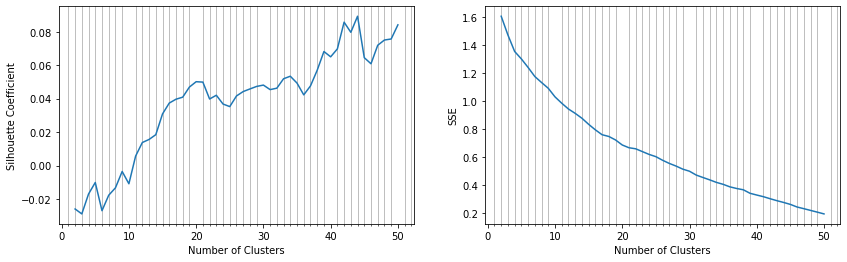

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

ax1.plot(k_range, silhouette_coef)
ax1.set_xticks(range(0,51,10))
ax1.xaxis.grid(True, which='minor')
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Coefficient')

ax2.xaxis.grid(True, which='minor')
ax2.plot(k_range, sse)
ax2.set_xticks(range(0,51,10))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('SSE')

plt.show()

In [37]:
kl = KneeLocator(x=k_range, y=sse, curve='convex', direction='decreasing')
kl.knee

20

In [38]:
# The elbow point at 20 is too large in comparison with 70-80 samples, select k=11, where also has 
# a elbow point and relatively large Sihouette coef.
kcluster = 11
kmeans = KMeans(n_clusters=kcluster, **kmeans_kwargs).fit(MA_clustering)

In [39]:
# add clustering labels
MA_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
MA_merged = MA_table.join(MA_Nei_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
MA_merged.dropna(inplace=True)

In [81]:
# create map
address = 'Manhattan, New York, NY'
g = geocoder.arcgis(address)
map_clusters = folium.Map(location=[g.lat, g.lng], zoom_start=12)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kcluster))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MA_merged['Latitude'], MA_merged['Longitude'], 
                                  MA_merged['Neighborhood'], MA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

/Applications/anaconda3/envs/my_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NameError: name 'ax' is not defined

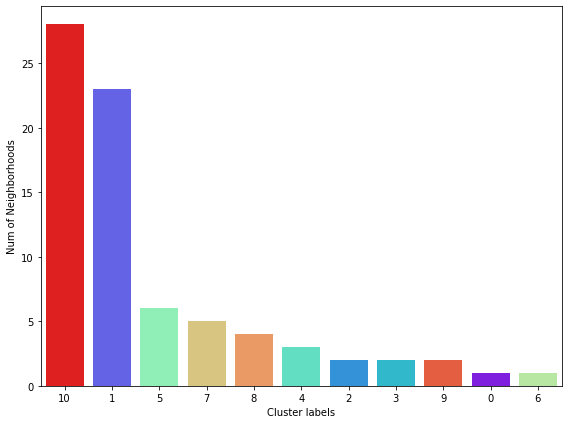

In [84]:
MA_cluster_rank = generate_cluster_rank(MA_merged)
plot_neighborhood_num(MA_cluster_rank)
# MA_top_clus, MA_clus_merged, MA_clus_freq = generate_clus_merged(MA_table, MA_grouped, MA_merged, MA_cluster_rank)
# plot_barplots(MA_top_clus, MA_clus_freq)

#### 3.1.1.2. Washington D.C.

In [26]:
k_range = range(2,51)
kmeans_kwargs = {
    'init': 'random',
    'n_init': 30,
    'max_iter': 300,
    'random_state': 0,
}

sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(DC_clustering)
    sse.append(kmeans.inertia_)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(DC_clustering)
silhouette_coef = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(DC_clustering)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coef.append(score)

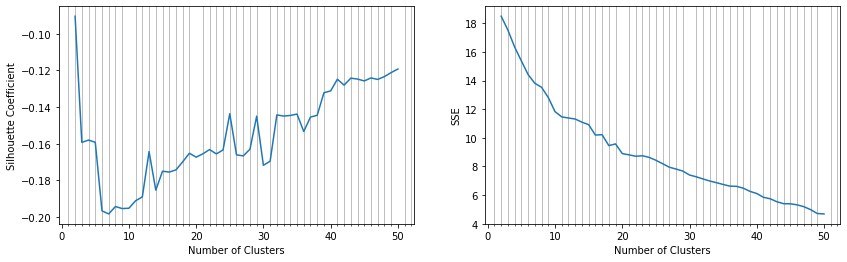

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

ax1.plot(k_range, silhouette_coef)
ax1.set_xticks(range(0,51,10))
ax1.xaxis.grid(True, which='minor')
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Coefficient')

ax2.xaxis.grid(True, which='minor')
ax2.plot(k_range, sse)
ax2.set_xticks(range(0,51,10))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('SSE')

plt.show()

In [28]:
kl = KneeLocator(x=k_range, y=sse, curve='convex', direction='decreasing')
kl.knee

11

In [29]:
kcluster = 11
kmeans = KMeans(n_clusters=kcluster, **kmeans_kwargs).fit(DC_clustering)

In [30]:
# add clustering labels
DC_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
DC_merged = DC_table.join(DC_Nei_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
DC_merged.dropna(inplace=True)

NameError: name 'DC_table' is not defined

In [ ]:
# create map
address = 'Washington, DC'
g = geocoder.arcgis(address)
map_clusters = folium.Map(location=[g.lat, g.lng], zoom_start=12)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kcluster))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DC_merged['Latitude'], DC_merged['Longitude'], 
                                  DC_merged['Neighborhood'], DC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 3.1.1.3. Shanghai

In [ ]:
k_range = range(2,51)
kmeans_kwargs = {
    'init': 'random',
    'n_init': 30,
    'max_iter': 300,
    'random_state': 0,
}

sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(SH_clustering)
    sse.append(kmeans.inertia_)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(SH_clustering)
silhouette_coef = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(SH_clustering)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coef.append(score)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

ax1.plot(k_range, silhouette_coef)
ax1.set_xticks(range(0,51,10))
ax1.xaxis.grid(True, which='minor')
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Coefficient')

ax2.xaxis.grid(True, which='minor')
ax2.plot(k_range, sse)
ax2.set_xticks(range(0,51,10))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('SSE')

plt.show()

In [ ]:
kl = KneeLocator(x=k_range, y=sse, curve='convex', direction='decreasing')
print(kl.knee, SH_clustering.shape[0])

In [ ]:
kcluster = 19
kmeans = KMeans(n_clusters=kcluster, **kmeans_kwargs).fit(SH_clustering)

In [ ]:
# add clustering labels
SH_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
SH_merged = SH_table.join(SH_Nei_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
SH_merged.dropna(inplace=True)

In [ ]:
# create map
address = 'Shanghai, China'
g = geocoder.arcgis(address)
map_clusters = folium.Map(location=[g.lat, g.lng], zoom_start=12)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kcluster))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SH_merged['Latitude'], SH_merged['Longitude'], 
                                  SH_merged['Neighborhood'], SH_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 3.1.1.3. Beijing

In [ ]:
k_range = range(2,51)
kmeans_kwargs = {
    'init': 'random',
    'n_init': 30,
    'max_iter': 300,
    'random_state': 0,
}

sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(BJ_clustering)
    sse.append(kmeans.inertia_)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(BJ_clustering)
silhouette_coef = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(BJ_clustering)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coef.append(score)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

ax1.plot(k_range, silhouette_coef)
ax1.set_xticks(range(0,51,10))
ax1.xaxis.grid(True, which='minor')
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Coefficient')

ax2.xaxis.grid(True, which='minor')
ax2.plot(k_range, sse)
ax2.set_xticks(range(0,51,10))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('SSE')

plt.show()

In [ ]:
kl = KneeLocator(x=k_range, y=sse, curve='convex', direction='decreasing')
print(kl.knee, BJ_clustering.shape[0])

In [ ]:
kcluster = 19
kmeans = KMeans(n_clusters=kcluster, **kmeans_kwargs).fit(BJ_clustering)

In [ ]:
# add clustering labels
BJ_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
BJ_merged = BJ_table.join(BJ_Nei_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
BJ_merged.dropna(inplace=True)

In [ ]:
# create map
address = 'Beijing, China'
g = geocoder.arcgis(address)
map_clusters = folium.Map(location=[g.lat, g.lng], zoom_start=12)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kcluster))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BJ_merged['Latitude'], BJ_merged['Longitude'], 
                                  BJ_merged['Neighborhood'], BJ_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3.2. Combine Venues and Analysis

In [ ]:
a = MA_grouped_clustering.append(DC_grouped_clustering)

In [ ]:
b = SH_grouped_clustering.append(BJ_grouped_clustering)

In [ ]:
c = a.append(b)

In [ ]:
c.reset_index()
complete = c.fillna(0)

In [619]:
def combine_func(df, new_column, columns):
    df[new_column] = pd.Series(dtype='float64')
    df[new_column] = df[new_column].fillna(0)

    for column in columns:
        df[new_column] = df[column] + df[new_column]
    df.drop(columns=columns, inplace=True)
    return df

In [620]:
complete_squ = complete
print(complete_squ.shape)
complete_squ = combine_func(complete_squ, 'Nightlife & Bar_squ', ['Speakeasy', 'Beer Bar', 'Bar', 'Cocktail Bar', 'Dive Bar', 'Gastropub', 'Sports Bar', 'Nightclub', 'Bistro', 'Strip Club',
                                                                  'Gay Bar', 'Irish Pub', 'Pub', 'Sake Bar', 'Tiki Bar', 'Whisky Bar', 'Wine Bar', 'Hookah Bar', 'Jazz Club', 
                                                                  'Nightlife Spot', 'Piano Bar'])
complete_squ = combine_func(complete_squ, 'Gym_squ', ['Gym', 'Gym / Fitness Center', 'Gym Pool', 'Gymnastics Gym', 'Boxing Gym', 'Cycle Studio', 'Yoga Studio', 'Climbing Gym',
                                                      'Dance Studio', 'Pilates Studio'])
complete_squ = combine_func(complete_squ, 'Pet_squ', ['Pet Service', 'Pet Store'])
complete_squ = combine_func(complete_squ, 'Digital Entertain_squ', ['Arcade', 'Internet Cafe', 'Gaming Cafe'])
complete_squ = combine_func(complete_squ, 'Hotel_squ', ['Hostel', 'Hotel', 'Motel', 'Hotel Pool', 'Hotel Bar'])
print(complete_squ.shape)

(409, 458)
(409, 422)


In [621]:
# 2nd combine
complete_squ = combine_func(complete_squ, 'Further Education_squ', ['Martial Arts School', 'Music School', 'Cooking School'])
complete_squ = combine_func(complete_squ, 'Education Institute_squ', ['School', 'Student Center', 'Elementary School'])
complete_squ = combine_func(complete_squ, 'College & University_squ', ['General College & University', 'College Academic Building', 'College Arts Building', 'College Bookstore', 
                                                                       'College Cafeteria', 'College Theater', 'University', 'College Administrative Building',
                                                                       'College Library', 'College Quad'])
complete_squ = combine_func(complete_squ, 'Museum-Related Building_squ', ['History Museum', 'Planetarium', 'Museum', 'Science Museum', 'Art Museum'])
complete_squ = combine_func(complete_squ, 'Business Service_squ', ['Business Center', 'Business Service'])
complete_squ = combine_func(complete_squ, 'Beauty & Salon_squ', ['Tattoo Parlor', 'Tanning Salon', 'Salon / Barbershop', 'Nail Salon', 'Health & Beauty Service'])
complete_squ = combine_func(complete_squ, 'Winery_squ', ['Distillery', 'Brewery', 'Winery'])
complete_squ = combine_func(complete_squ, 'Zoo & Aquarium_squ', ['Zoo', 'Zoo Exhibit', 'Aquarium'])
complete_squ = combine_func(complete_squ, 'Cash Service_squ', ['Check Cashing Service', 'ATM'])
complete_squ = combine_func(complete_squ, 'Laundry Service_squ', ['Laundromat', 'Laundry Service', 'Dry Cleaner'])
complete_squ = combine_func(complete_squ, 'Metro Station_squ', ['Light Rail Station', 'Metro Station'])
complete_squ = combine_func(complete_squ, 'Bus Service_squ', ['Bus Station', 'Bus Stop'])
complete_squ = combine_func(complete_squ, 'Travel Service_squ', ['Train Station', 'General Travel', 'Airport Lounge'])
complete_squ = combine_func(complete_squ, 'Religious Venues_squ', ['Church', 'Synagogue', 'Temple'])
complete_squ = combine_func(complete_squ, 'Medical Center_squ', ['Hospital', 'Medical Center'])
complete_squ = combine_func(complete_squ, 'Memorial & Lankmark_squ', ['Memorial Site', 'Historic Site', 'Monument / Landmark', 'Scenic Lookout'])
complete_squ = combine_func(complete_squ, 'Outdoors Venue_squ', ['Tourist Information Center', 'Construction & Landscaping', 'Other Great Outdoors', 'Park', 'Theme Park', 
                                                                 'Dog Run', 'Lake', 'Theme Park Ride / Attraction', 'Waterfront', 'Trail', 'Garden', 'Garden Center',
                                                                 'Botanical Garden', 'Skate Park'])
complete_squ = combine_func(complete_squ, 'Sports Stadium_squ', ['Football Stadium', 'Soccer Stadium', 'Tennis Stadium', 'Baseball Stadium', 'Stadium'])
complete_squ = combine_func(complete_squ, 'Sports Field_squ', ['Golf Course', 'Track', 'Pool Hall', 'Volleyball Court', 'Tennis Court', 'Bowling Alley', 'Moving Target', 'Pool',
                                                               'Soccer Field', 'Skating Rink', 'Playground', 'College Basketball Court'])
complete_squ = combine_func(complete_squ, 'Entertainment_squ', ['Escape Room', 'Theater', 'Concert Hall', 'Indie Movie Theater', 'Indie Theater', 'Circus', 'Entertainment Service',
                                                                'General Entertainment', 'Movie Theater', 'Opera House', 'Music Venue'])
complete_squ = combine_func(complete_squ, 'Social_squ', ['Social Club', 'Comedy Club', 'Club House'])
complete_squ = combine_func(complete_squ, 'Drink Shop_squ', ['Juice Bar', 'Ice Cream Shop', 'Coffee Shop', 'Bubble Tea Shop', 'Frozen Yogurt Shop', 'Pet Café', 'Tea Room', 'Café',
                                                             'Smoothie Shop'])
complete_squ = combine_func(complete_squ, 'Clothing Shop_squ', ['Boutique', 'Clothing Store', 'Tailor Shop'])
complete_squ = combine_func(complete_squ, 'Food Shop_squ', ['Health Food Store', 'Bagel Shop', 'Candy Store', 'Cheese Shop', 'Chocolate Shop', 'Dessert Shop', 'Cupcake Shop', 
                                                             'Donut Shop', 'Creperie', 'Pastry Shop', 'Souvlaki Shop'])
complete_squ = combine_func(complete_squ, 'Fast Food_squ', ['Fried Chicken Joint', 'Food', 'Food & Drink Shop', 'Food Court', 'Food Stand', 'Food Truck', 'Hot Dog Joint',
                                                            'Mac & Cheese Joint', 'Salad Place', 'Sandwich Place', 'Snack Place', 'Taco Place', 'Wings Joint', 
                                                            'Chinese Breakfast Place', 'BBQ Joint', 'Burger Joint', 'Burrito Place', 'Churrascaria', 'Deli / Bodega', 
                                                            'Cha Chaan Teng', 'Fish & Chips Shop', 'Street Food Gathering', 'Breakfast Spot', 'Pizza Place', 'Soup Place',
                                                            'Poke Place'])
complete_squ = combine_func(complete_squ, 'Art_squ', ['Art Gallery', 'Street Art', 'Arts & Entertainment', 'Exhibit', 'Performing Arts Venue', 'Sculpture Garden', 'Outdoor Sculpture',
                                                      'Public Art'])
complete_squ = combine_func(complete_squ, 'Plaza_squ', ['Shopping Plaza', 'Pedestrian Plaza', 'Plaza'])
complete_squ = combine_func(complete_squ, 'Market_squ', ['Christmas Market', 'Market', 'Flea Market', 'Fish Market', 'Farmers Market'])

In [622]:
columns_list = complete.columns.tolist()
restaurant_list = []
for name in columns_list:
    if name.find('Restaurant')!= -1:
        restaurant_list.append(name)
complete_squ = combine_func(complete_squ, 'Restaurant_squ', restaurant_list+['Buffet', 'Noodle House', 'Steakhouse', 'Diner'])
print(complete_squ.shape)

(409, 180)


In [623]:
complete_squ.columns.tolist()

['Accessories Store',
 'Adult Boutique',
 'Amphitheater',
 'Animal Shelter',
 'Antique Shop',
 'Arts & Crafts Store',
 'Athletics & Sports',
 'Auditorium',
 'Baby Store',
 'Bakery',
 'Bank',
 'Baseball Field',
 'Basketball Court',
 'Basketball Stadium',
 'Bed & Breakfast',
 'Beer Garden',
 'Beer Store',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bike Shop',
 'Bike Trail',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Bridal Shop',
 'Bridge',
 'Building',
 'Butcher',
 'Cafeteria',
 'Camera Store',
 'Comic Shop',
 'Community Center',
 'Convenience Store',
 'Cosmetics Shop',
 'Coworking Space',
 'Daycare',
 'Department Store',
 'Design Studio',
 'Discount Store',
 "Doctor's Office",
 'Drugstore',
 'Electronics Store',
 'Event Space',
 'Eye Doctor',
 'Factory',
 'Flower Shop',
 'Fountain',
 'Furniture / Home Store',
 'Gas Station',
 'Gift Shop',
 'Gourmet Shop',
 'Grocery Store',
 'Harbor / Marina',
 'Hardware Store',
 'Heliport',
 'Hill',
 'Hobby Shop',
 'Home Service',
 'Jewelry

In [633]:
kclusters = 10
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(complete_squ)

<AxesSubplot:xlabel='x', ylabel='Count'>

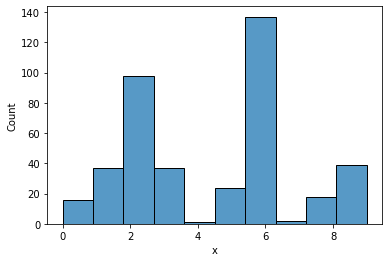

In [634]:
hist = pd.DataFrame(kmeans.labels_, columns= ['x'])
sns.histplot(data=hist, x='x')

In [635]:
MA = MA_grouped.shape[0]
DC = DC_grouped.shape[0]
SH = SH_grouped.shape[0]
BJ = BJ_grouped.shape[0]

In [636]:
MA_label = kmeans.labels_[0 : MA]
DC_label = kmeans.labels_[MA : MA+DC]
SH_label = kmeans.labels_[MA+DC : MA+DC+SH]
BJ_label = kmeans.labels_[MA+DC+SH : MA+DC+SH+BJ]